In [1]:
import numpy as np
#import gromacs
import pandas as pd
import os, fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import MDAnalysis as mda
import pickle
from scipy import signal
from scipy.ndimage.filters import uniform_filter1d
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Function definitions
a few handy functions with a quite general meaning 

In [2]:
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [3]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
    supplied root directory.'''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield os.path.join(path, filename)

In [4]:
def symmetrize(a):
    """ 
    a - array to be symmetrized mirror-like, with the mirror symmetry placed in the centre
    returns: a tuple with the symmetrized array (half the size), 
             and the resulting standard deviation in the second place of the tuple
    """
    d = a.shape[0]   #assuming index=0
    m = d//2         # the middle-of-array index -- integer division here
    l = a[:m]        # left part
    r = np.ndarray(l.shape)
    for i in range(m):
        r[i] = a[-i-1]
    s = np.average(np.vstack((l, r)), axis=0)
    e = np.std(np.vstack((l, r)), axis=0)
    return (s, e)

In [5]:
def cropstring(s, l=None, r=None):
    """
    Returns a cropped substring of a string s
    
     l, r : strings
            strings or patterns (RegEx not implemented!) to match in string s
            for cropping after l and before r
    """
    if isinstance(l, str):
        il = s.find(l) + len(l)
    else:
        il = 0
    if isinstance(r, str):
        ir = s.find(r)
    else:
        ir = len(s)+1  #till the end of the original string
    return s[il:ir]

# Simulation class definition
This class includes all methods and attributes to obtain results from ethanol-membrane intreraction simulations with Martini within **permeability** project with Jacopo Fralicciardi and Bert Poolman.

This is prepared in a way that the readout shall be easily concatenated in a Pandas Dataframe for further analysis including multi-indexing etc...

In [6]:
class Simulation:
    '''Simulation class stores and accesses simulation data 
    relevant for ethanol - membrane interaction project with Martini'''
    default_top_fname             = "topol.tpr"
    default_traj_fname            = "traj_comp_pbc.xtc"
    default_lipidator_fname       = "lipidator.out"
    default_solvent_density_fname = "density_solvent.xvg"
    default_boxx_fname            = "boxx.xvg"
    use_symmetry = True
    column_labels = ("satur index",
                     "sterol conc",
                     "particle",
                     "starting conf",
                     "compress",
                     "perm", "perm err")

    def __init__(self, dirname):
        self.dirname = dirname
        # the dirname containing conditions of the simulation
        # is not parsed at the beginning (only done when needed in method parse_dirname)
        self.dirname_parsed = False
        # check presence of required files
        self.top_fname             = Simulation.default_top_fname
        self.traj_fname            = Simulation.default_traj_fname
        self.lipidator_fname       = Simulation.default_lipidator_fname
        self.solvent_density_fname = Simulation.default_solvent_density_fname
        self.boxx_fname            = Simulation.default_boxx_fname
        for fname in [self.top_fname, ]: # self.lipidator_fname, self.solvent_density_fname, self.boxx_fname]:
            try:
                for f in locate(fname, self.dirname):
                    if fname in f:
                        temp_found_file0 = f
                    break
            except:
                print("something went wrong with locating {} in dir:\n{}".format(fname, self.dirname))    
        # get the topology using MDAnalysis
        # this is not used at this moment, so creating mda.Universe is skipped
        if False:
            try:
                self.topology = mda.Universe(os.path.join(self.dirname, self.top_fname)) 
            except:
                raise UserWarning("Error loading topology and trajectory in directory {}".format(self.dirname))
            
            
    
    def calc_perm(self, m=20, use_symmetry=True, const_fric=None):
        """
        calculate permeability from AWH simulation deltaG and friction profiles
        
        parameter m defines the number of samples from each side of the profile
        to use for estimation of the zero-level 
        by taking mean on the left & right (which are obtained independently and have to agree in a converged sim.) 
        and comparing the values
        
        returns tuple with two values (permeability and , its err.estim.)
        """
        
        # locate the awh file (friction file has the same naming convention format, se we will only simply substitute)
        awh_files = locate("awh_*.xvg", self.dirname)
        # choose the newest of the files
        try:
            newest_file = max(awh_files, key=os.path.getctime)
        except:
            print("cannot find newest file in dir {} \n setting perm to None values".format(sim.dirname))
            return (None, None)
        
        # assign the AWH data sets to numpy arrays
        awh_data  = np.loadtxt(newest_file, comments=("#", "@"))
        x    = awh_data[:,0]
        fep  = awh_data[:,1]

        # prepare friction data - from file (implicit) or constant (optional)
        if not const_fric:
            fric_data = np.loadtxt(newest_file.replace("/awh_", "/friction_"), comments=("#", "@"))
            fric = fric_data[:,1]
        else:
            # OVERRIDING friction data with a constant number
            fric = np.ones(fep.shape)*const_fric
            
        # store the AWH, x-coord & friction profile as attributes of this class Simulation
        self.awh_x = x
        self.awh   = fep
        self.fric  = fric
            
        # obtain the estimate of deltaG from left & right
        dg1 = np.max(fep-fep[-m:].mean())
        dg2 = np.max(fep-fep[:m].mean())
        self.dg    = np.mean([dg1, dg2])
        self.dgstd = np.std([dg1, dg2])
        
        # calculate the permeability (through 1/resistance)
        if use_symmetry:
            # apply symmetry rules to the profile and obtain an estimate of error
            fepsymm  = symmetrize(fep)
            fricsymm = symmetrize(fric)
            xsymm    = x[:fepsymm[0].shape[0]]
            rxsymm    = np.exp(fepsymm[0]-fepsymm[0][:m].mean())*fricsymm[0]/1000.0    # r(x) = resistance
            # use value of 100.0 instead of "*fricsymm[1]" to simplify the equation and error estimate?
            rxstdsymm = ( np.exp(fepsymm[0])*fricsymm[1] + np.exp(fepsymm[1])*fricsymm[0] )/1000.0    # error of r(x) through chain rule
            r         = np.trapz(x=xsymm[m:], y=rxsymm[m:]) *2.0   # *2, because i have only half of the profile after symmetrizing it
            rstd      = np.trapz(x=xsymm[m:], y=rxstdsymm[m:]) *2.0
        else:
            # set the zero-level (solvent) to 0 from one resp. other side
            rx1  = np.exp(fep-fep[-m:].mean())*fric/1000.0    # r(x) ...
            rx2  = np.exp(fep-fep[:m].mean()) *fric/1000.0    # resistance in ns/nm resp s/m
            r = np.trapz(x=x[m:-m], y=np.vstack((rx1, rx2))[:,m:-m])

        unit_scaling_factor = 100000.0  # provides unit cm/s *e-3 from simulation units (kT and ps)d
        perm      = unit_scaling_factor/r   # in nm/us*e-4 resp cm/s*e-3
        try: 
            permstd = perm**2 * rstd /unit_scaling_factor   # is the same as: perm*rstd/r
        except:
            permstd = None

        self.__perm_perr = (perm, permstd)
        return (perm, permstd)

    
    @property
    def perm(self):
        try:
            return self.__perm_perr[0]
        except:
            # shall be raised e.g. in case self.apl is not defined yet
            self.calc_perm()  # defines the above self."attribute"
        finally:
            return self.__perm_perr[0]

    @property
    def permerr(self):
        try:
            return self.__perm_perr[1]
        except:
            # shall be raised e.g. in case self.apl is not defined yet
            self.calc_perm()  # defines the above self."attribute"
        finally:
            return self.__perm_perr[1]
        
    
    def read_lipidator(self):
        """get several properties,
        bending and tilt moduli [in units kT and kT/nm^2],
        area per lipid (incl. stderr & stdev) [in units nm^2], 
        from lipidator file"""
        try:
            with open(os.path.join(self.dirname, self.lipidator_fname), "r") as lefile:
                for line in lefile.readlines():
                    linesplit = line.split()
                    if line.startswith("Monolayer Bending"):
                        bending = float(linesplit[linesplit.index('kappa')+1])
                    if line.startswith("Bilayer Tilt"):
                        tilt    = float(linesplit[linesplit.index('kappa')+1])
                    if line.startswith(" Area AVG"):
                        apl       = float(linesplit[linesplit.index('[bilayer]:')+1]) *0.01
                        aplstderr = float(linesplit[linesplit.index('[bilayer]:')+4]) *0.01
                        aplstdev  = float(linesplit[linesplit.index('[bilayer]:')+6]) *0.01
                        
        except IOError:
            print("Problems loading the lipidator file in dir {}".format(self.dirname))
        except:
            print("Generally some problems in loading Lipidator output -- check code.")
        finally:
            try:
                self.__bend       = bending
                self.__tilt       = tilt
                self.__apl        = apl
                self.__apl_stderr = aplstderr
                self.__apl_stdev  = aplstdev
            except:
                # will be raised e.g. in case any of the above is not defined 
                # (e.g. weren't accessed via the method above)
                self.__bend = self.__tilt = self.__apl = self.__apl_stderr = self.__apl_stdev = None
        return (bending, tilt, apl, aplstderr, aplstdev)
    
    
    @property
    def apl(self):
        try:
            return self.__apl
        except:
            # shall be raised e.g. in case self.apl is not defined yet
            self.read_lipidator()  # defines the above self.apl
        finally:
            return self.__apl
    

    @property
    def tilt(self):
        try:
            return self.__tilt
        except:
            # shall be raised e.g. in case self.apl is not defined yet
            self.read_lipidator()  # defines the above self.apl
        finally:
            return self.__tilt
    

    @property
    def bend(self):
        try:
            return self.__bend
        except:
            # shall be raised e.g. in case self.apl is not defined yet
            self.read_lipidator()  # defines the above self.apl
        finally:
            return self.__bend
    
    
    def calc_thick(self):
        """
        method calculating Luzzati thickness (hydrophobic thickness) 
        from a density profile xvg file
        """
        try:
            # variable wat also accounts for generally any solvent (e.g. water+ethanol solution)
            dens_arr = np.loadtxt(os.path.join(self.dirname, self.solvent_density_fname), comments=["#", "@"])
            wat = dens_arr[:,1]
            x   = dens_arr[:,0]
            d_z = np.abs(x[-1]-x[0])         # simulation box z-length , aka repeat distance
            bulkwatdens = np.mean(wat[:10])
            wat /= bulkwatdens
            h   = d_z - np.trapz(wat, x)
            #print(x, wat, bulkwatdens, d_z, h)
        except IOError:
            print("Problems loading the density_ethanol_water XVG file in dir {}".format(self.dirname))
            h = None
        except:
            print("Generally some problems in the density_ethanol_water loading resp. Luzzati thickness calc -- check code.")
            h = None
        finally:
            self.__thick = h
            return thick                


    @property
    def thick(self):
        try:
            return self.__thick
        except:
            # shall be raised e.g. in case self.__thick is not defined yet
            self.calc_thick()
        finally:
            return self.__thick

            
    #    Copied from below - turn into methods!
    def calc_compressibility(self):
        """
        method calculating 
        Area Compressibility modulus [in units kT/nm^2]
        from Box-x xvg file - a time-series of box-x (data : np.array)
        using the fluctuation theorem  
        """
        try:
            data_arr = np.loadtxt(os.path.join(self.dirname, self.boxx_fname), comments=["#", "@"])
            x_t = data_arr[:,1]
            a_t = x_t**2
            a_0 = a_t.mean()
            var =  a_t.var()
            ka = a_0/var
        except IOError:
            print("Problems loading the box-x XVG file in dir {}".format(self.dirname))
            ka = None
        except:
            print("Generally some problems in the Box-x loading/calc -- check code.")
            ka = None
        finally:
            self.__compress = ka
            return ka
           
            
    @property
    def compress(self):
        try:
            return self.__compress
        except:
            # shall be raised e.g. in case self.apl is not defined yet
            self.calc_compressibility()  # defines the above self."attribute"
        finally:
            return self.__compress
 

    def parse_dirname(self):
        """
        Dirname parser assigning values to 
        simulation conditions (temperature)
        and compositions (saturation number d, which lipids, what sterols and how much..)
        as instance attributes
        
        This method is HIGHLY SPECIFIC to the permeability project 
        and the dirname naming conventions therein
        """
        s = self.dirname # just a short-hand abbreviation for the long self.dirname 
        self.sterol_type     = cropstring(s, l="./", r="sterol")
        self.sterol_conc  =int(cropstring(s, l=self.sterol_type+"sterol", r="p_PC"))
        self.temperature  = 293  # as in the main mdp file
        self.particle = cropstring(s, "perm_particle_EOL", "/sat-unsat")
        self.d = float(cropstring(s, "_d_", "/sim1"))/100.0  # saturation index d
        self.starting_conf = cropstring(s, "_awh_")
        # and finally, the dirname path was parsed, so ...
        self.dirname_parsed  = True
        
    
    @property
    def satur_index(self):
        """
        Assign a saturation index d depending on the used tails
        
        NOT USED in this project
        """
        raise Warning("Invoking function >> satur_index <<, which shall not be used!")
        try:
            self.tails
        except:
            self.parse_dirname()
        finally:
            t = self.tails
            if t == "DP":
                d = 0.0
            elif t == "PO":
                d = 0.5
            elif t == "DO" or t == "PI":
                d = 1.0
            elif t == "DI":
                d = 2.0
            else:
                d = None
        self.sat_ind = d
        return d
    
    
    @property
    def as_record(self):
        """
        Export the single Simulation instance as a record (a tuple of items)
        The order is given by the Class variable Simulation.column_labels
        """
        try:
            self.d
        except:
            self.parse_dirname()
        finally:    
            record = (self.d, 
                      self.sterol_conc, 
                      self.particle,
                      self.starting_conf,
                      self.compress,
                      self.perm, self.permerr)

        return record

# Search through the simulations
on my local disk on md39.

In the following section, I will loop through the simulation folders and 
obtain results from my analysis scripts.

This will be put together in a Pandas Dataframe with multiindexing at the end. 

The multiindex will use properties as parsed from the directory names.

In [10]:
tpr_files = find("topol.tpr", os.curdir)

In [11]:
tpr_files

['./sim2_awh_fluid_AWHk2k_pull10k_linear_SC6/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_SP6/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_N5/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_SN3/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_SC5/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_SN5/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_N1/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_SP1/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_SP3/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_SN1/topol.tpr',
 './sim2_awh_fluid_AWHk2k_pull10k_linear_SN2/topol.tpr']

In [23]:
sims    = []
for f in tpr_files:
    sim = Simulation(os.path.dirname(f))
    sims.append(sim)

In [173]:
sim.dirname
sim.thick

Problems loading the density_ethanol_water XVG file in dir ./sim2_awh_fluid_AWHk2k_pull10k_linear_SN2


# AWH profiles plotting
As working with the pickled objects also requires defining the Simulation class,
I will make the AWH-profile plots here in this notebook. 

## DOPC with permants of various POW
In the following plots, I will show the dG profiles 
from permeations with various solutes of varying solubility. 

In [49]:
# define the particle name. 
# luckily it is always 3 character long, so this is simple
for s in sims:
    s.pname = s.dirname[-3:]
    # calculate permeability and record the profiles
    print("Sim in dir {}\n has permeability {} +/- {} cm/s e-3".format(s.dirname, s.perm, s.permerr))
        

Sim in dir ./sim2_awh_fluid_AWHk2k_pull10k_linear_SC5
 has permeability 11545.712111621013 +/- 56768.30172969576 cm/s e-3
Sim in dir ./sim2_awh_fluid_AWHk2k_pull10k_linear_SC6
 has permeability 12769.91680278084 +/- 66265.41238238575 cm/s e-3
Sim in dir ./sim2_awh_fluid_AWHk2k_pull10k_linear_SN1
 has permeability 10359.593555077241 +/- 34103.37260852875 cm/s e-3
Sim in dir ./sim2_awh_fluid_AWHk2k_pull10k_linear_SN2
 has permeability 7047.14623078723 +/- 18587.195594667977 cm/s e-3
Sim in dir ./sim2_awh_fluid_AWHk2k_pull10k_linear_SN3
 has permeability 2049.3280059103663 +/- 1617.0865539178283 cm/s e-3
Sim in dir ./sim2_awh_fluid_AWHk2k_pull10k_linear_SN5
 has permeability 401.9713726772274 +/- 80.0339980750461 cm/s e-3
Sim in dir ./sim2_awh_fluid_AWHk2k_pull10k_linear_SP1
 has permeability 96.82906041874399 +/- 35.67818107627855 cm/s e-3
Sim in dir ./sim2_awh_fluid_AWHk2k_pull10k_linear_SP3
 has permeability 34.6187234832542 +/- 4.288315108873823 cm/s e-3
Sim in dir ./sim2_awh_fluid_AW

Now, sort the lists after the particle name:

In [50]:
sims.sort(key=lambda s: s.pname)

### Free energy profiles

in the code below,
I plot the symmetrized AWH-free energy profiles.
The differences from symmetrization 
give rise to the error estimates included in the plot. 

The plot can be futher improved 
by using a simulation snapshot as a background. 

In [159]:
selected_particles = ["SC5", "SP3", "SP6", "SN3", "SN2"]
sns.set_palette("viridis", n_colors=len(selected_particles))

In [161]:
def prep_to_plot(x, y, shift_to_zero=True, filt_freq=None, runmeansize=10):
    """Function symmetrizes and shifts the profiles for plotting."""
    ysymm_arr = symmetrize(y)
    # apply filter to get rid of some noise
    if filt_freq:
        b, a = signal.butter(4, filt_freq)
        ysymm_arr = signal.filtfilt(b, a, ysymm_arr, padlen=0)

    ys    = ysymm_arr[:][0]
    yserr = ysymm_arr[:][1]
    x_half = -x[:len(ys)]
    if shift_to_zero:
        delta = ys[:50].mean()
        ys -= delta
    return (x_half, ys, yserr)

Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SC5
Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SN2
Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SN3
Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SP3
Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SP6


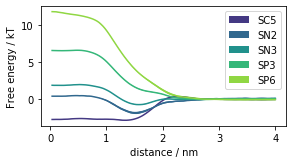

In [172]:
for sim_list, xxpc in zip([sims, ], ["DOPC", ]):
    for s in sim_list:
        if (xxpc == 'DOPC') and s.pname in selected_particles:
            print("Working with sim in dri {}".format(s.dirname))
            try:
                    (x_half, awhsym, awhsym_err) = prep_to_plot(s.awh_x, s.awh)
                    plt.plot(x_half, awhsym)  #, label="{}".format(s.pname))
                    if True:
                        plt.fill_between(x=x_half, 
                                     y1=awhsym+awhsym_err,
                                     y2=awhsym-awhsym_err,
                                     label="{}".format(s.pname))
            except:
                print("troubles plotting simulation in {}".format(s.dirname))

    plt.legend()
    fig = plt.gca()
    fig.figure.set_size_inches([4.4,2.2])
    #plt.ylim([-1, 11])
    plt.ylabel("Free energy / kT")
    plt.xlabel("distance / nm")
    plt.savefig("awh_dG_profiles_{}_various-particles.png".format(xxpc), dpi=150, bbox_inches='tight')
    plt.show()

### Friction profiles

in the code below,
I plot the symmetrized friction profiles.
The differences from symmetrization 
give rise to the error estimates included in the plot. 

These plots would benefit from further processing,
namely smoothening of the noise. 

However, at the current status it makes the necessary points. 

Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SC5
Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SN2
Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SN3
Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SP3
Working with sim in dri ./sim2_awh_fluid_AWHk2k_pull10k_linear_SP6


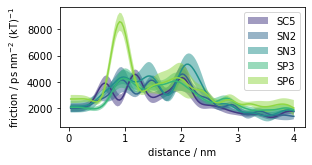

In [171]:
# Butterworth filter of 4th degree with a Nyquist freq of 100Hz (Low pass filter)
b, a = signal.butter(4, 0.080)

for sim_list, xxpc in zip([sims, ], ["DOPC", ]):
    for s in sim_list:
        if (xxpc == 'DOPC') and s.pname in selected_particles:
            print("Working with sim in dri {}".format(s.dirname))
            # applied Butterworth filter on the friction profile
            (x_half, fricsym, fricsym_err) = prep_to_plot(s.awh_x, s.fric, shift_to_zero=False, filt_freq=0.150)
            x_half = -s.awh_x[:len(fricsym)]
            plt.plot(x_half, fricsym)  #, label="{}".format(s.pname))
            #plt.plot(x_half, fricsym_filt, label="{}".format(s.pname))
            if True:
                        plt.fill_between(x=x_half, 
                                         y1=fricsym+fricsym_err,
                                         y2=fricsym-fricsym_err,
                                         label="{}".format(s.pname),
                                         alpha=0.5)
    plt.legend()
    fig = plt.gca()
    fig.figure.set_size_inches([4.4,2.2])
    plt.ylabel("friction / ps nm$^{-2}$ (kT)$^{-1}$")
    plt.xlabel("distance / nm")
    plt.savefig("friction_profiles_{}_various-particles.png".format(xxpc), dpi=150, bbox_inches='tight')
    plt.show()